In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

np.random.seed(12345)

In [2]:
color_map = {i: c for i, c in enumerate(sns.color_palette())}

In [3]:
format_num = '{:,.0f}'.format

## Import data

In [4]:
draws = pd.read_csv('../data/processed/draws.csv', index_col=0)
shares = pd.read_csv('../data/processed/shares.csv')
outlets = pd.read_csv('../data/processed/outlets.csv')
structure = pd.read_csv('../data/processed/structure.csv')

Add computed column `format` to `draws` table

In [5]:
draws.insert(0, 'format', '456')
draws.loc[draws.index >= 2995, 'format'] = '496'
draws.loc[draws.index >= 3568, 'format'] = '496C1'
draws.loc[draws.index >= 3604, 'format'] = '496C2'
draws.loc[draws.index >= 3644, 'format'] = '496'
draws.loc[draws.index >= 3664, 'format'] = '496C1'
draws.loc[draws.index >= 3692, 'format'] = '496'

Winning `numbers` go to a separate table 

In [6]:
numbers = draws.loc[:, 'win_1':'additional']
draws.drop(columns=['win_1', 'win_2', 'win_3', 'win_4', 'win_5', 'win_6', 'additional', 'total_distributed', 'total_allocated'], inplace=True)

In [7]:
draws.head()

,format,draw_date,week,day_of_week,is_hong_bao,prize_pool,snowballed_1,snowballed_2,consecutive,discrepency
draw_no,,,,,,,,,,
1335,456,"Thu, 12 Nov 1998",1998W46,4,0,1439536,0,0,0,75616
1336,456,"Mon, 16 Nov 1998",1998W47,1,0,2184513,500000,0,1,-76646
1337,456,"Thu, 19 Nov 1998",1998W47,4,0,3834538,1195596,0,2,-1345
1338,456,"Mon, 23 Nov 1998",1998W48,1,0,9521025,2460753,0,3,-3229
1339,456,"Thu, 26 Nov 1998",1998W48,4,0,1534315,0,0,0,-912


In [8]:
numbers.head()

,win_1,win_2,win_3,win_4,win_5,win_6,additional
draw_no,,,,,,,
1335,1,2,22,25,28,39,4
1336,9,18,22,32,34,39,15
1337,1,2,7,28,35,37,40
1338,7,23,34,36,42,43,37
1339,10,21,24,25,36,42,41


In [9]:
shares.head()

,draw,group,shareAmount,numberOfShares,snowballed,cascaded
0,1335,Group 1,500000,0,NaN,NaN
1,1335,Group 2,187090,1,NaN,NaN
2,1335,Group 3,1853,101,NaN,NaN
3,1335,Group 4,709,264,NaN,NaN
4,1335,Group 5,30,5964,NaN,NaN


In [10]:
outlets.head()

,draw,group,outlet,quickpick,bet_type
0,1338,Group 1,Nan Huat Wine Store - Blk 513 Bishan St 13 #01...,1,System 7 Entry
1,1339,Group 1,Seng Yeok Chan Agency - Blk 338 Ang Mo Kio Ave...,0,System Roll Entry
2,1340,Group 1,Milly Trading Store - Blk 374 Bukit Batok St 3...,1,Ordinary Entry
3,1340,Group 1,Papillon Florist Pte Ltd - Blk 133 Jalan Bukit...,0,Ordinary Entry
4,1342,Group 1,Vijaya Darshana Agency - 810 Geylang Rd City P...,1,System 8 Entry


- Add computed columns `distributed` and `allocated` to `shares` table
- Add computed columns `total_distributed`, `total_allocated` and `total_collected` to `draws` table
- Compute draw `payoff` as the ratio between `total_distributed` and `total_collected`

In [11]:
shares['distributed'] = shares['shareAmount'] * shares['numberOfShares']
shares['allocated'] = np.maximum(shares['distributed'], shares['shareAmount']) - shares['snowballed'].fillna(0) - shares['cascaded'].fillna(0)

draws['total_distributed'] = shares.groupby('draw')['distributed'].sum()
draws['total_allocated'] = shares.groupby('draw')['allocated'].sum()
draws['total_collected'] = draws['prize_pool'] / 0.5
draws['payoff'] = draws['total_distributed'] / draws['total_collected']

pd.concat([draws.iloc[:, -4:-1].applymap(format_num), draws['payoff']], axis=1).head()

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/2995890263.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.concat([draws.iloc[:, -4:-1].applymap(format_num), draws['payoff']], axis=1).head()


,total_distributed,total_allocated,total_collected,payoff
draw_no,,,,
1335,"904,459","1,404,459","2,879,072",0.314149
1336,"1,484,950","2,180,546","4,369,026",0.339881
1337,"2,403,260","3,668,417","7,669,076",0.313370
1338,"11,453,121","8,992,368","19,042,050",0.601465
1339,"1,441,537","1,441,537","3,068,630",0.469766


Sanity check

In [12]:
draws[['total_distributed', 'total_allocated', 'prize_pool']].sum(axis=0).apply(format_num)

total_distributed    9,614,678,459
total_allocated      9,615,920,156
prize_pool           9,480,694,710
dtype: object

## Number appearance

Melt `numbers`

In [13]:
numbers.reset_index(inplace=True)

In [14]:
numbers_melted = numbers.melt(id_vars=['draw_no'], var_name='label')
numbers_melted.head()

,draw_no,label,value
0,1335,win_1,1
1,1336,win_1,9
2,1337,win_1,1
3,1338,win_1,7
4,1339,win_1,10


Count appearance

In [15]:
number_appearance_456 = numbers_melted[numbers_melted['draw_no'] < 2995].groupby('value')['value'].count()
number_appearance_496 = numbers_melted[numbers_melted['draw_no'] >= 2995].groupby('value')['value'].count()

Normalize by the number of draws

In [16]:
number_appearance_456 /= (draws['format'] == '456').sum()
number_appearance_496 /= (draws['format'] == '496').sum()

Normalize by theoretical probability

In [17]:
number_appearance_456 /= 7 / 45
number_appearance_496 /= 7 / 49

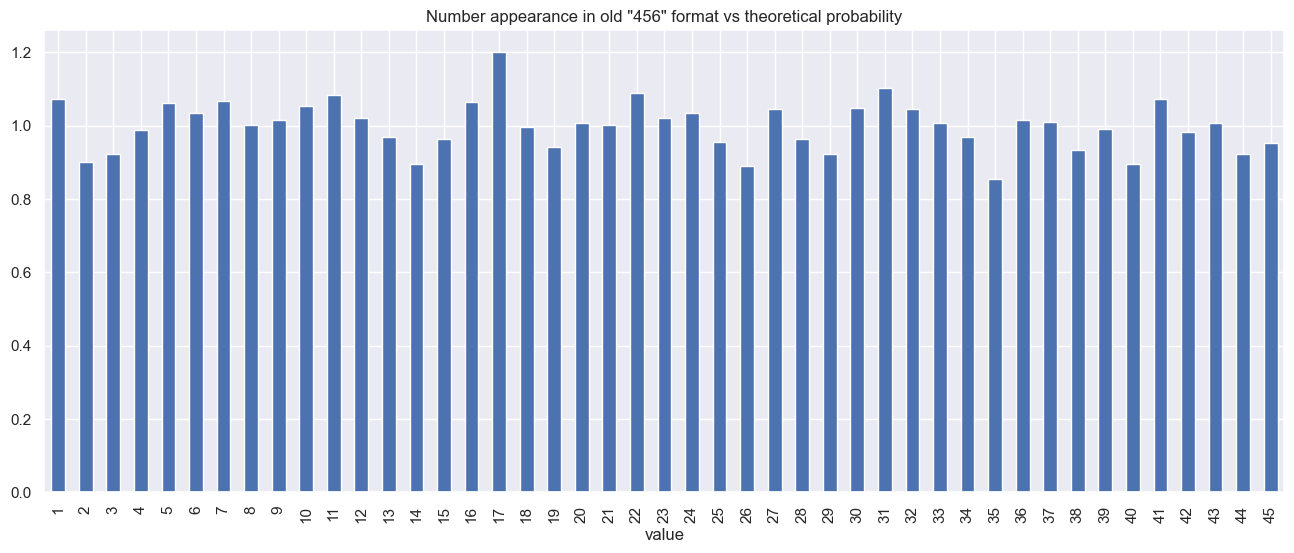

In [18]:
ax = number_appearance_456.plot.bar(figsize=(16,6))
ax.set_title('Number appearance in old "456" format vs theoretical probability');

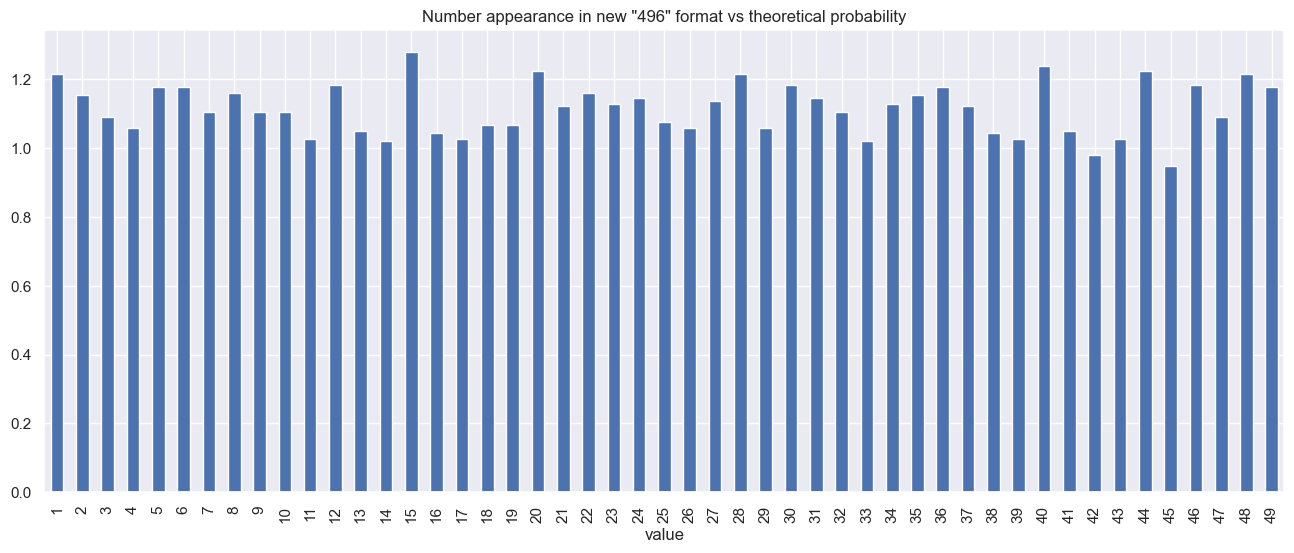

In [19]:
ax = number_appearance_496.plot(kind='bar', figsize=(16,6))
ax.set_title('Number appearance in new "496" format vs theoretical probability');

**Observation**: No observable pattern. Observed frequencies mostly fall between between 0.8 and 1.2 of theoretical probability. Number 45 in format "496" seems like an anomaly. We can further breakdown by draw appearance.

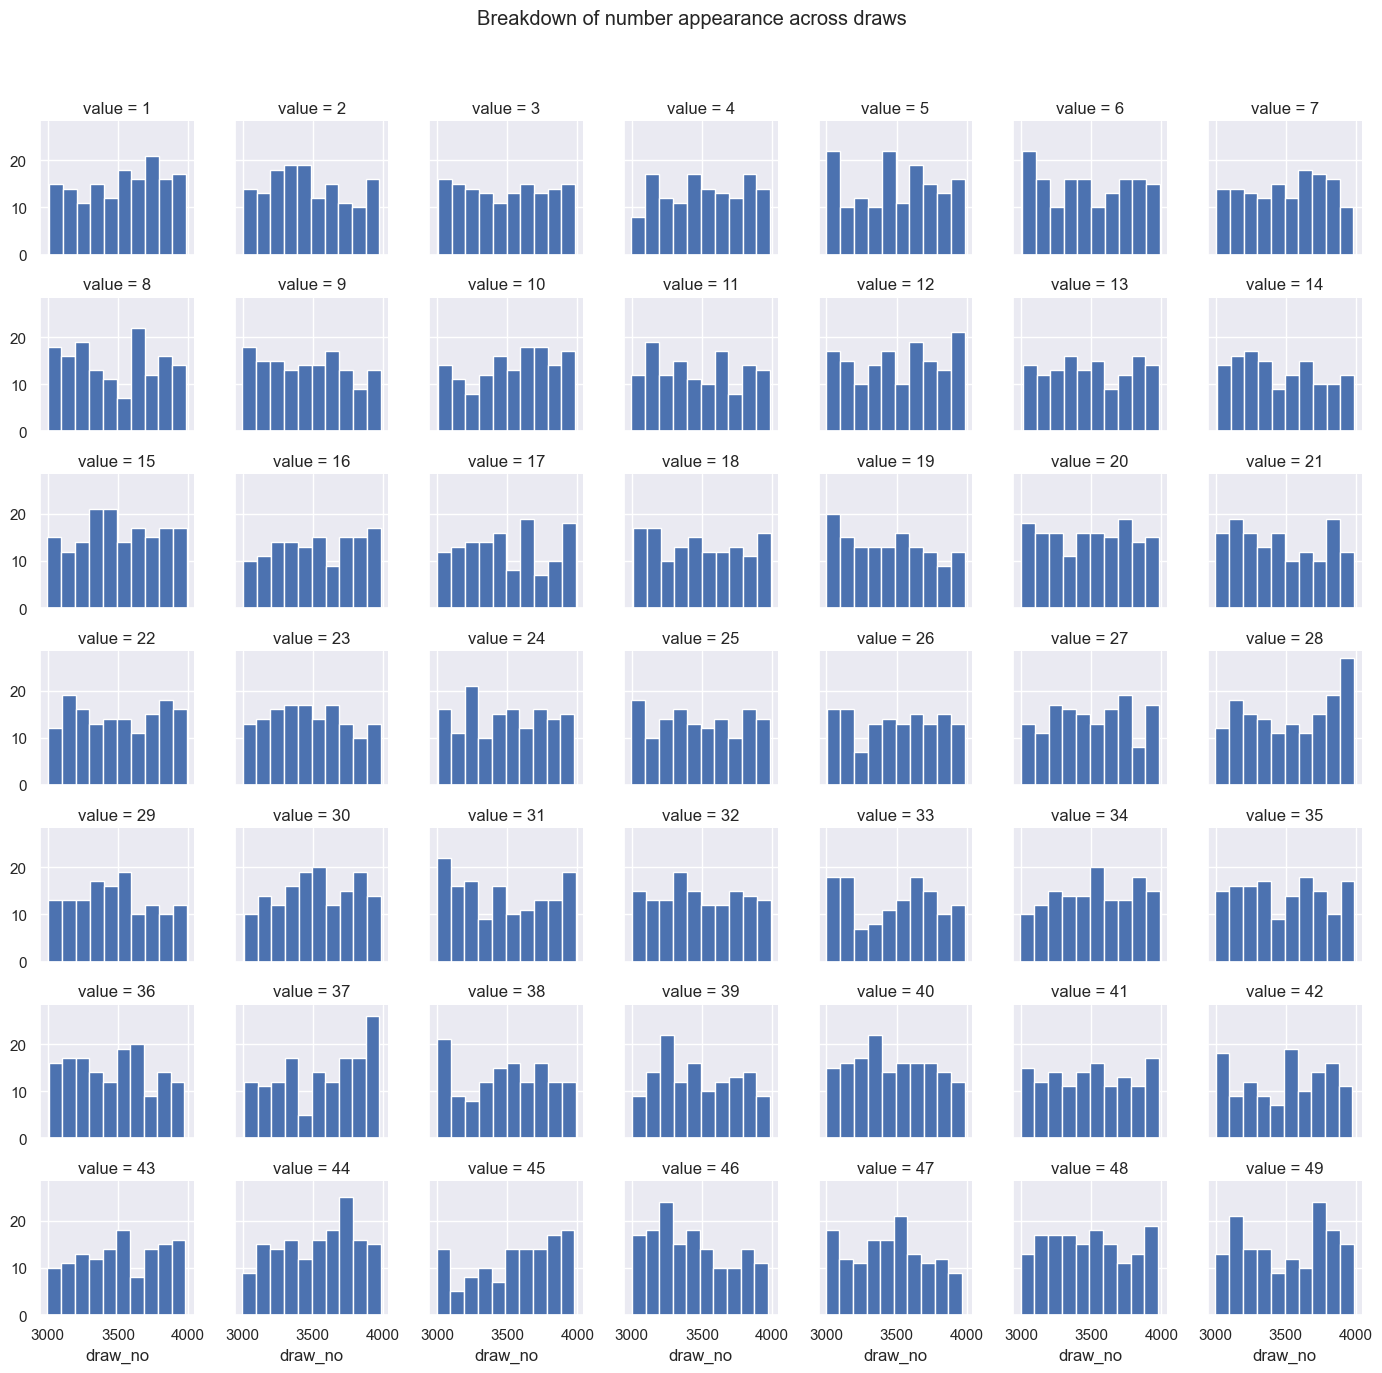

In [20]:
g = sns.FacetGrid(numbers_melted[numbers_melted['draw_no'] >= 2995], col='value', col_wrap=7, height=2)
g = g.map(plt.hist, 'draw_no')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Breakdown of number appearance across draws');

## Most popularity numbers

Focus on additional number. Pivot `shares` to count number of `Group 2`, `Group 4` and `Group 6` winners in each draw.

In [21]:
numbers.set_index('draw_no', inplace=True)

In [22]:
shares_pvt = pd.pivot_table(shares, values='numberOfShares', index='draw', columns='group')
shares_pvt['format'] = draws['format']
shares_pvt['additional'] = numbers['additional']
pd.concat([shares_pvt.loc[:, 'Group 1':'Group 7'].applymap(format_num), shares_pvt.loc[:, 'format':'additional']], axis=1).head()

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/1367487847.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.concat([shares_pvt.loc[:, 'Group 1':'Group 7'].applymap(format_num), shares_pvt.loc[:, 'format':'additional']], axis=1).head()


group,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,format,additional
draw,,,,,,,,,
1335,0,1,101,264,"5,964","8,206",nan,456,4
1336,0,4,212,616,"10,085","16,522",nan,456,15
1337,0,10,320,875,"17,131","19,681",nan,456,40
1338,1,29,796,"2,192","38,351","49,335",nan,456,37
1339,1,4,160,291,"5,971","7,885",nan,456,41


Create `num_attrs` table which will be useful later for spotting pattern.

In [23]:
num_attrs = pd.DataFrame({'num': range(1, 50)})
num_attrs['first_digit'] = num_attrs['num'] // 10
num_attrs['last_digit'] = num_attrs['num'] % 10
num_attrs['row'] = (num_attrs['num'] - 1) // 9
num_attrs['col'] = (num_attrs['num'] - 1) % 9
num_attrs.set_index('num', inplace=True)
num_attrs.tail()

,first_digit,last_digit,row,col
num,,,,
45,4,5,4,8
46,4,6,5,0
47,4,7,5,1
48,4,8,5,2
49,4,9,5,3


Add computed columns `incl_additional` and `tickets_sold`

- `incl_additional` counts number of `Group 2`, `Group 4` and `Group 6` winners. Winning tickets in these groups definitely include the additional number.
- `total_stakes` allows us to normalize by total tickets sold in that draw.

In [24]:
shares_pvt['incl_additional'] = shares_pvt['Group 2'] + shares_pvt['Group 4'] + shares_pvt['Group 6']
stake_price = draws['format'].map({'456': 0.5, '496': 1.0, '496C1': 1.0, '496C2': 1.0})
shares_pvt['total_stakes'] = draws['total_collected'] / stake_price
shares_pvt.loc[:, 'format':'total_stakes'].head()

group,format,additional,incl_additional,total_stakes
draw,,,,
1335,456,4,8471.0,5758144.0
1336,456,15,17142.0,8738052.0
1337,456,40,20566.0,15338152.0
1338,456,37,51556.0,38084100.0
1339,456,41,8180.0,6137260.0


Compute theoretical probabilty of winning `Group 2`, `Group 4` or `Group 6`

In [25]:
norm_factor_456 = structure[(structure['format'] == 456) & (structure['bet_type'] == 'Ordinary') & (structure['match'].isin(['Group 2', 'Group 4', 'Group 6']))]['probability'].sum()
norm_factor_496 = structure[(structure['format'] == 496) & (structure['bet_type'] == 'Ordinary') & (structure['match'].isin(['Group 2', 'Group 4', 'Group 6']))]['probability'].sum()
print(norm_factor_456, norm_factor_496)

0.001796917395329094 0.001276904673230721


In [26]:
def get_popularity(df, norm_factor):
    output = pd.pivot_table(df, values=['incl_additional', 'total_stakes'], index='additional')
    output['norm_popularity'] = output['incl_additional'] / output['total_stakes']  / norm_factor
    return output.join(num_attrs)

In [27]:
def layout_numbers(data, rows, cols, pad):
    arr = np.array(data)
    return np.pad(arr, (0, rows * cols - len(arr)), 'constant', constant_values=(pad, pad)).reshape(rows, cols)

Find most and least popular numbers

In [28]:
popularity_456 = get_popularity(shares_pvt[draws['format'] == '456'], norm_factor_456)
popularity_456_sorted = popularity_456.sort_values('norm_popularity', ascending=False)
popularity_456_sorted['norm_popularity'].iloc[[0, -1]]

additional
9     1.226148
44    0.756327
Name: norm_popularity, dtype: float64

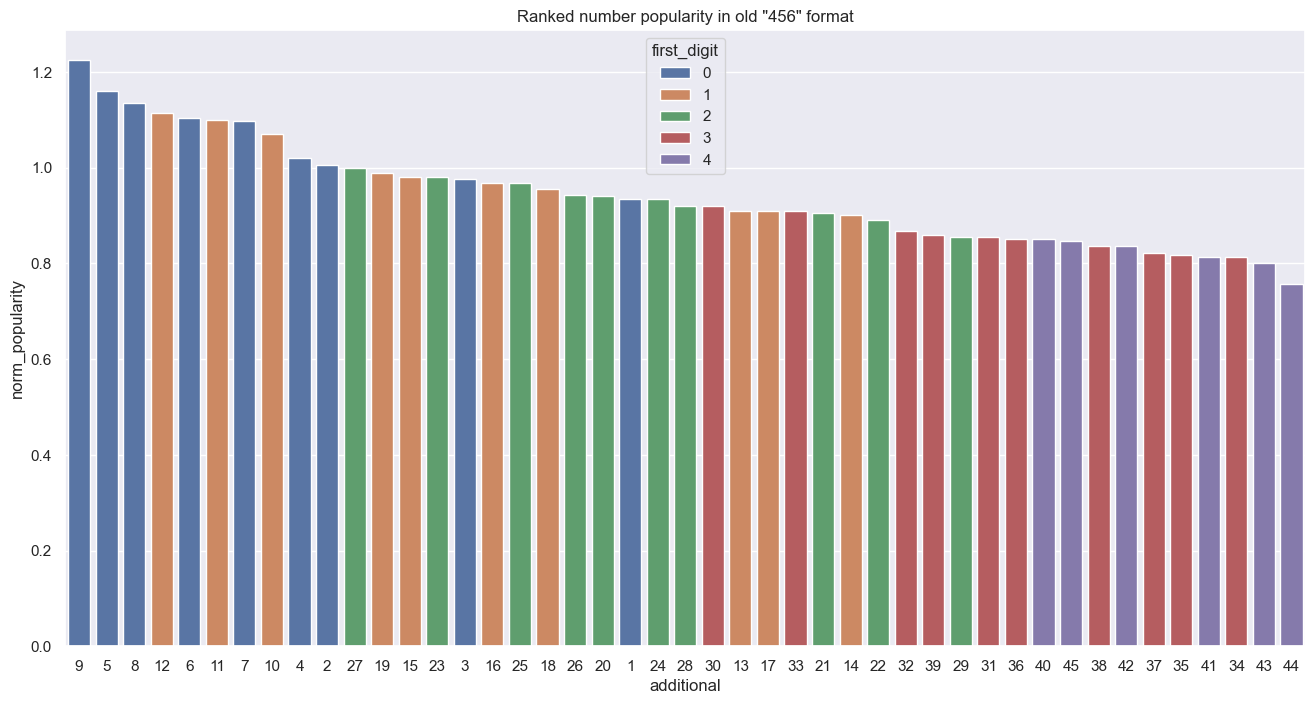

In [29]:
plt.figure(figsize=(16,8))
ax = sns.barplot(data=popularity_456, x=popularity_456.index, y='norm_popularity', hue='first_digit', order=popularity_456_sorted.index, dodge=False)
ax.set_title('Ranked number popularity in old "456" format');

Layout number popularity on a heatmap

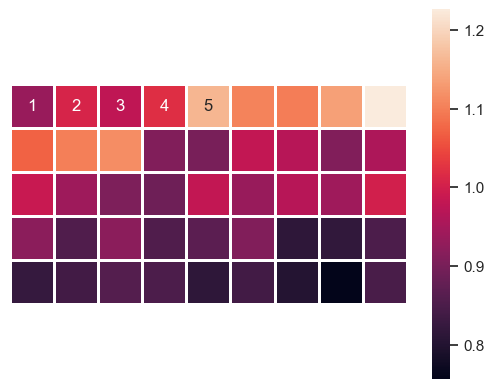

In [30]:
sns.heatmap(data=layout_numbers(popularity_456['norm_popularity'], 5, 9, 1), annot=layout_numbers(popularity_456.index, 5, 9, 0),
            square=True, linewidths=2, xticklabels=False, yticklabels=False);

Most and least popular number after changing to "496" format

In [31]:
popularity_496 = get_popularity(shares_pvt[draws['format'] == '496'], norm_factor_496)
popularity_496_sorted = popularity_496.sort_values('norm_popularity', ascending=False)
popularity_496_sorted['norm_popularity'].iloc[[0, -1]]

additional
5     1.268863
47    0.767144
Name: norm_popularity, dtype: float64

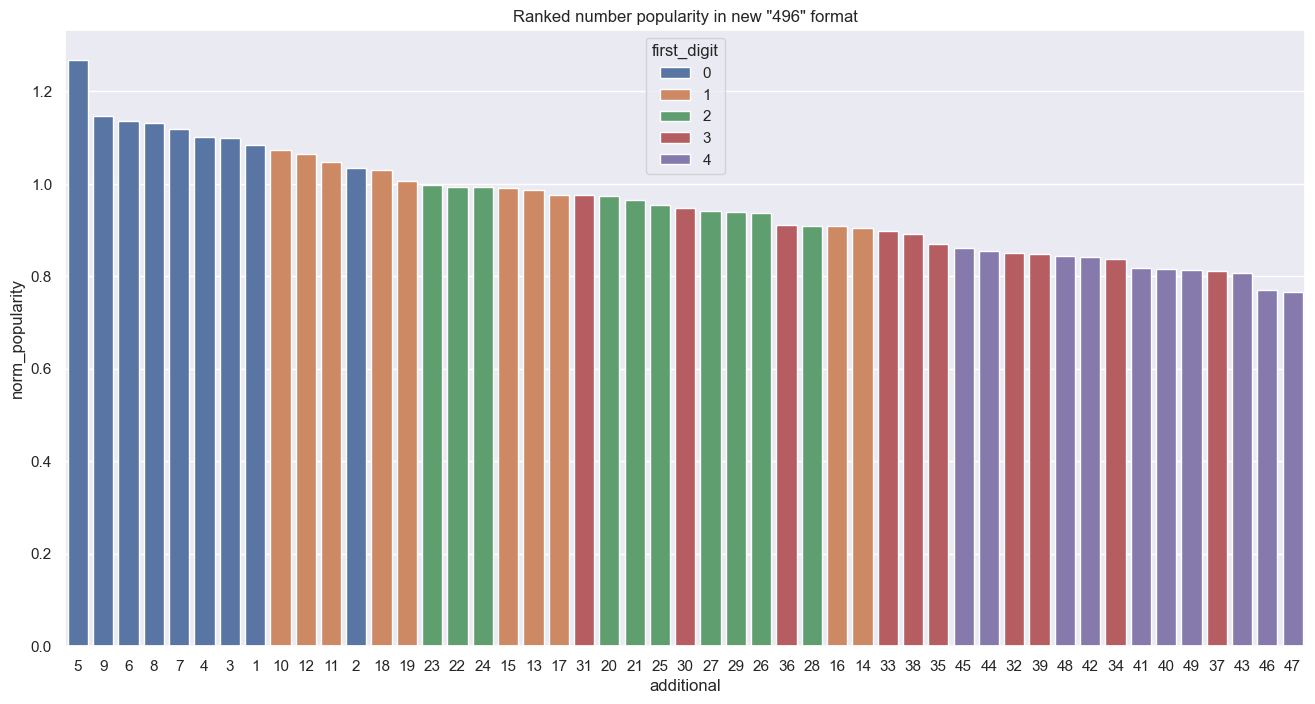

In [32]:
plt.figure(figsize=(16,8))
ax = sns.barplot(data=popularity_496, x=popularity_496.index, y='norm_popularity', hue='first_digit', order=popularity_496_sorted.index, dodge=False)
ax.set_title('Ranked number popularity in new "496" format');

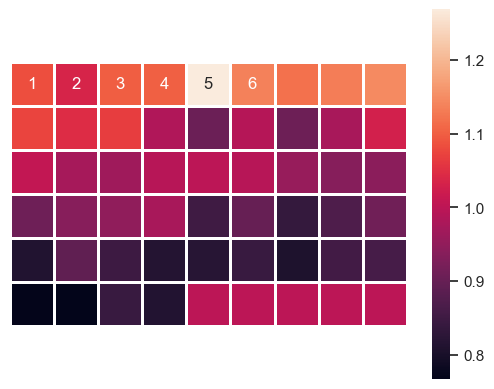

In [33]:
sns.heatmap(data=layout_numbers(popularity_496['norm_popularity'], 6, 9, 1), annot=layout_numbers(popularity_496.index, 6, 9, 0),
            square=True, linewidths=2, xticklabels=False, yticklabels=False);

## Classification

Exclude draws with too few participants (jackpot prize topped up to minimum guaranteed amount)

In [34]:
min_draws = shares[
    (shares['group'] == 'Group 1') &
    (((shares['allocated'] == 500000) & (shares['draw'] < 2995)) | ((shares['allocated'] == 1000000) & (shares['draw'] >= 2995)))
]['draw']
min_draws = set(min_draws)
min_draws

{1335, 1341, 1351, 1549, 1635, 1707, 3025, 3569, 3578, 3584, 3588}

In [35]:
draws['minimum'] = draws.index.isin(min_draws)

Group into `usual_draws`, `hong_bao_draws` and `friday_draws`

In [36]:
draws['unusual'] = draws['minimum'] | (draws['discrepency'] > 100000) | (draws['day_of_week'] == 5) | (draws['is_hong_bao'] == 1)
usual_draws = draws[(draws.index < 3568) & ~draws['unusual']].copy()
hong_bao_draws = draws[draws['is_hong_bao'] == 1].copy()
friday_draws = draws[draws['unusual'] & ~draws['minimum'] & (draws['is_hong_bao'] == 0)].copy()

## Usual draws

### Breakdown of average receipt in usual draws

In [37]:
receipt_stat = usual_draws.groupby(['format', 'consecutive'])['total_collected'].describe()
receipt_stat.applymap(format_num)

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/174918493.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  receipt_stat.applymap(format_num)


count        mean        std         min         25%  \
format consecutive                                                         
456    0            1,019   3,985,291    779,803   2,921,082   3,623,901   
       1              433   5,616,194    825,766   4,369,026   5,102,006   
       2              140   8,887,281  1,580,472   6,429,220   7,811,447   
       3               22  16,313,235  3,496,136  12,319,976  13,698,532   
496    0              232   5,946,138    586,434   5,030,110   5,609,754   
       1              170   7,708,532  1,429,511   5,956,044   7,270,022   
       2              106  11,116,145  1,055,453   8,153,078  10,462,614   
       3               52  19,509,170  3,355,113  12,532,726  17,103,329   

                           50%         75%         max  
format consecutive                                      
456    0             3,943,130   4,130,066  12,267,556  
       1             5,572,770   6,015,886  12,386,184  
       2             8,934,528   9,702,195  18,375,434  
       3            15,851,384  18,032,354  24,863,682  
496    0             5,833,002   6,090,638  10,206,272  
       1             7,610,241   7,938,744  24,149,548  
       2            11,073,726  11,804,000  14,124,440  
       3            18,877,842  22,900,002  24,810,532

Overall average

In [38]:
mean_receipt = usual_draws.groupby('format')['total_collected'].mean()
mean_receipt

format
456    5.016068e+06
496    8.719183e+06
Name: total_collected, dtype: float64

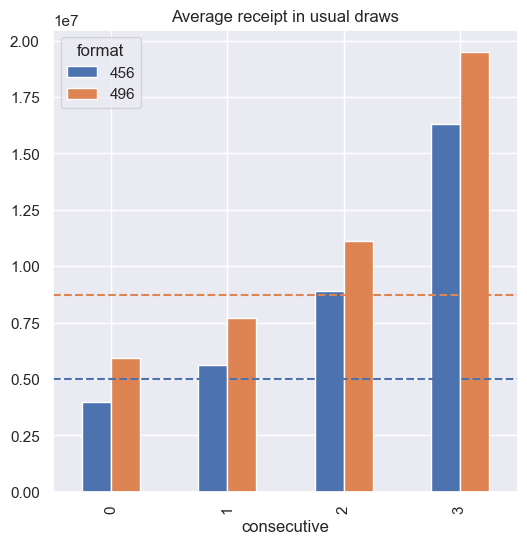

In [39]:
ax = receipt_stat.swaplevel('format', 'consecutive')['mean'].unstack().plot.bar(figsize=(6, 6))
ax.axhline(mean_receipt['456'], color=color_map[0], linestyle='--')
ax.axhline(mean_receipt['496'], color=color_map[1], linestyle='--')
ax.set_title('Average receipt in usual draws');

**Observation**: The average receipt from usual draws is 5M in old "456" format and increased to 8.7M in new "495" format.

### Breakdown of times snowballed

In [40]:
total_draws_by_format = usual_draws.groupby('format')['draw_date'].count()

In [41]:
receipt_stat['percent_count'] = receipt_stat['count'] / receipt_stat.index.get_level_values(0).map(total_draws_by_format) * 100
receipt_stat['percent_count'].unstack().applymap('{:.1f}%'.format)

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/3745635225.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  receipt_stat['percent_count'].unstack().applymap('{:.1f}%'.format)


consecutive,0,1,2,3
format,,,,
456,63.1%,26.8%,8.7%,1.4%
496,41.4%,30.4%,18.9%,9.3%


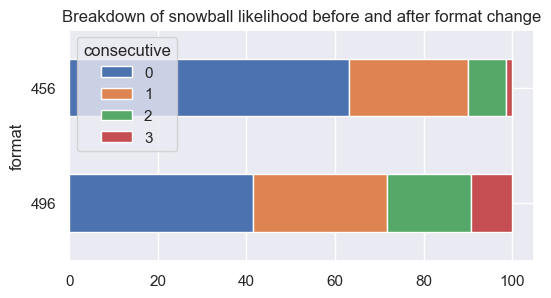

In [42]:
ax = receipt_stat['percent_count'].unstack().iloc[::-1, :].plot.barh(stacked=True, figsize=(6, 3));
ax.set_title('Breakdown of snowball likelihood before and after format change');

**Observation**: After the format change, the likelihood of snowball and cascade draw (3 consecutive snowball) increased significantly. It is more likely to have a snowball draw than a non-snowball draw.

### Cascade draws

In [43]:
is_cascade = draws['consecutive'] == 3
cascaded = shares.groupby('draw')['cascaded'].sum() > 0
cascade_stat = pd.DataFrame({'format': draws['format'], 'is_cascade': is_cascade, 'cascaded': cascaded}, index=draws.index)
cascade_stat[draws.index < 3568].groupby('format').agg(draws=('is_cascade', 'size'), cascade_draws=('is_cascade', 'sum'), cascaded=('cascaded', 'sum'))

,draws,cascade_draws,cascaded
format,,,
456,1660,23,0
496,573,54,19


**Observation**: Not only has cascade draws become much more frequent after format change, the likelihood of the cascade actually being effected has increased too.

## Special draws

In [44]:
hong_bao_draws

,format,draw_date,week,day_of_week,is_hong_bao,prize_pool,snowballed_1,snowballed_2,consecutive,discrepency,total_distributed,total_allocated,total_collected,payoff,minimum,unusual
draw_no,,,,,,,,,,,,,,,,
1465,456,"Thu, 10 Feb 2000",2000W06,4,1,18194385,0,0,0,15143797,22815240,22815240.0,36388770.0,0.626986,False,True
1567,456,"Thu, 01 Feb 2001",2001W05,4,1,14299854,0,0,0,16008864,19150750,19150750.0,28599708.0,0.669613,False,True
1678,456,"Mon, 25 Feb 2002",2002W09,1,1,19689754,1299345,0,1,15147101,25619861,24320516.0,39379508.0,0.650589,False,True
1779,456,"Thu, 13 Feb 2003",2003W07,4,1,18445385,0,0,0,15139500,23346602,23346602.0,36890770.0,0.632858,False,True
1881,456,"Thu, 05 Feb 2004",2004W06,4,1,19839556,0,0,0,10597410,22976196,22976196.0,39679112.0,0.579050,False,True
1989,456,"Thu, 17 Feb 2005",2005W07,4,1,19272972,0,0,0,11198665,22782839,22782839.0,38545944.0,0.591057,False,True
2091,456,"Fri, 10 Feb 2006",2006W06,5,1,22389526,0,0,0,9084074,25885943,25885943.0,44779052.0,0.578082,False,True
2201,456,"Fri, 02 Mar 2007",2007W09,5,1,22782010,0,0,0,9077493,25724540,25724540.0,45564020.0,0.564580,False,True
2303,456,"Thu, 21 Feb 2008",2008W08,4,1,21868303,0,0,0,9080728,25069638,25069638.0,43736606.0,0.573196,False,True


In [45]:
friday_draws

,format,draw_date,week,day_of_week,is_hong_bao,prize_pool,snowballed_1,snowballed_2,consecutive,discrepency,total_distributed,total_allocated,total_collected,payoff,minimum,unusual
draw_no,,,,,,,,,,,,,,,,
1453,456,"Thu, 30 Dec 1999",1999W52,4,0,16714336,0,0,0,15140519,21420953,21420953.0,33428672.0,0.640796,False,True
1877,456,"Fri, 23 Jan 2004",2004W04,5,0,2684071,0,0,0,-1440,2563301,2563301.0,5368142.0,0.477502,False,True
2159,456,"Fri, 06 Oct 2006",2006W40,5,0,10204782,732852,0,1,5750491,12667877,11935025.0,20409564.0,0.620683,False,True
2237,456,"Fri, 06 Jul 2007",2007W27,5,0,10249146,790325,0,1,5746596,14749277,13958952.0,20498292.0,0.719537,False,True
2259,456,"Fri, 21 Sep 2007",2007W38,5,0,8249633,0,0,0,7722758,10745826,10745826.0,16499266.0,0.651291,False,True
2329,456,"Fri, 23 May 2008",2008W21,5,0,8575579,0,0,0,6657730,12156568,12156568.0,17151158.0,0.708790,False,True
2351,456,"Fri, 08 Aug 2008",2008W32,5,0,15569959,0,0,0,8747932,18032668,18032668.0,31139918.0,0.579085,False,True
2433,456,"Fri, 22 May 2009",2009W21,5,0,9962910,0,0,0,5451741,11811810,11811810.0,19925820.0,0.592789,False,True
2469,456,"Fri, 25 Sep 2009",2009W39,5,0,12609251,1750774,0,2,11571991,17817562,16066788.0,25218502.0,0.706527,False,True


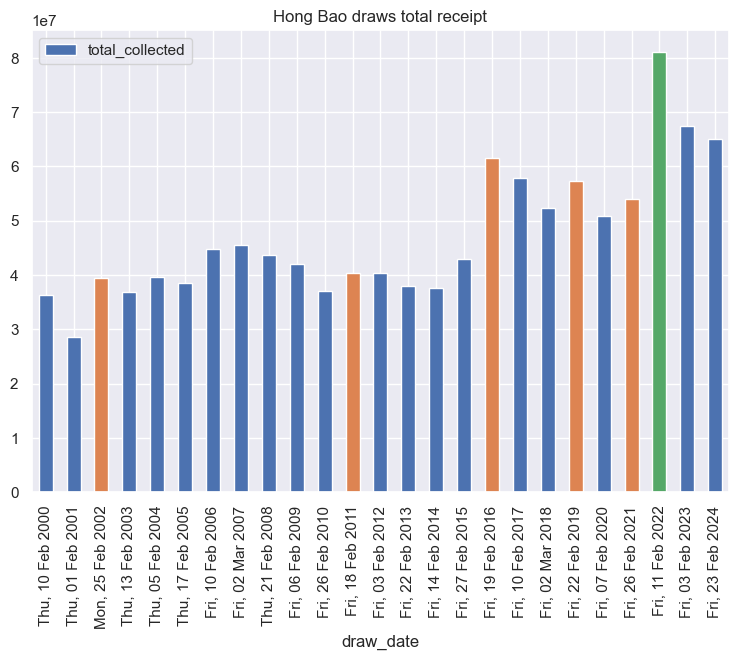

In [46]:
ax = hong_bao_draws.plot.bar(x='draw_date', y='total_collected', color=hong_bao_draws['consecutive'].map(color_map), figsize=(9, 6));
ax.set_title('Hong Bao draws total receipt');

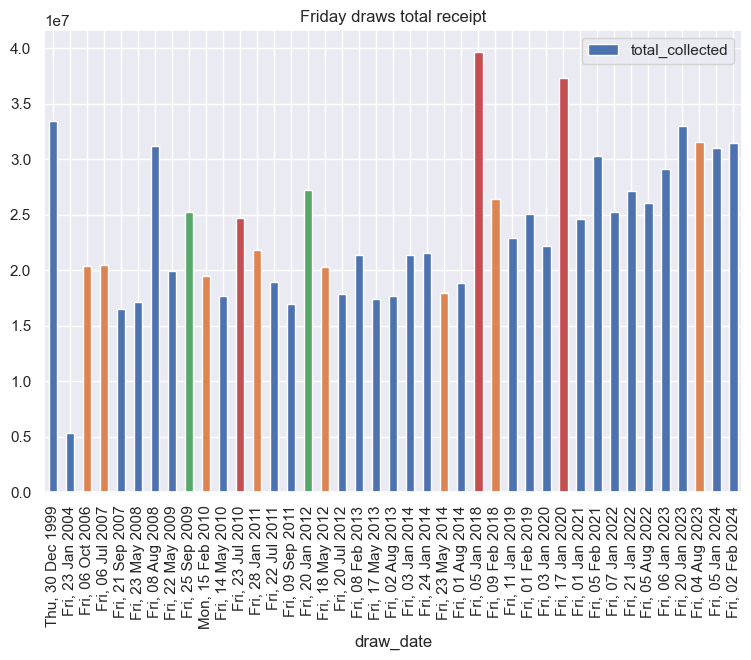

In [47]:
ax = friday_draws.plot.bar(x='draw_date', y='total_collected', color=friday_draws['consecutive'].map(color_map), figsize=(9, 6));
ax.set_title('Friday draws total receipt');

In [48]:
hong_bao_draws['total_collected'].mean(), friday_draws['total_collected'].mean()

(47167329.04, 23744869.36585366)

**Observation**: Friday draws pull receipts of 22M on average while Hong Bao draws pull receipts of 43M on average.

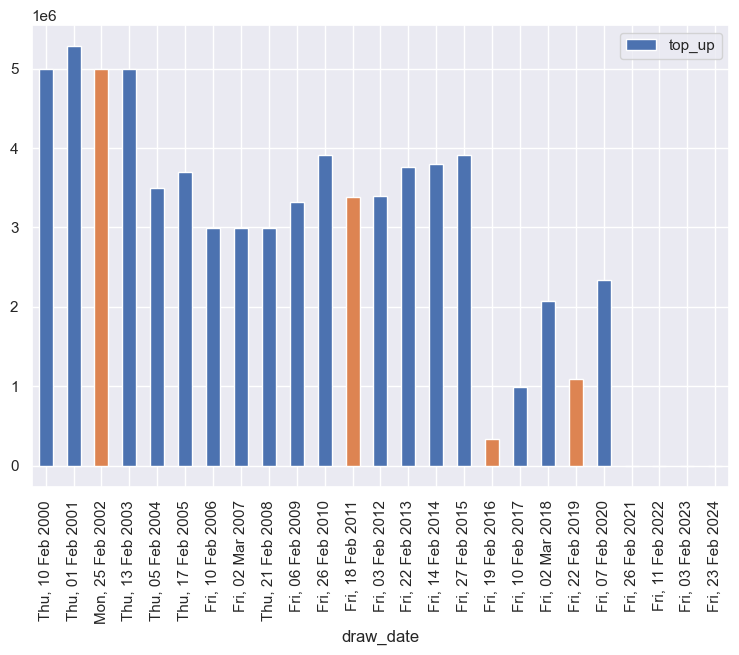

In [49]:
hong_bao_draws['top_up'] = hong_bao_draws['discrepency'] * hong_bao_draws['format'].map({'456': 0.33, '496': 0.38})
hong_bao_draws.plot.bar(x='draw_date', y='top_up', color=hong_bao_draws['consecutive'].map(color_map), figsize=(9, 6));

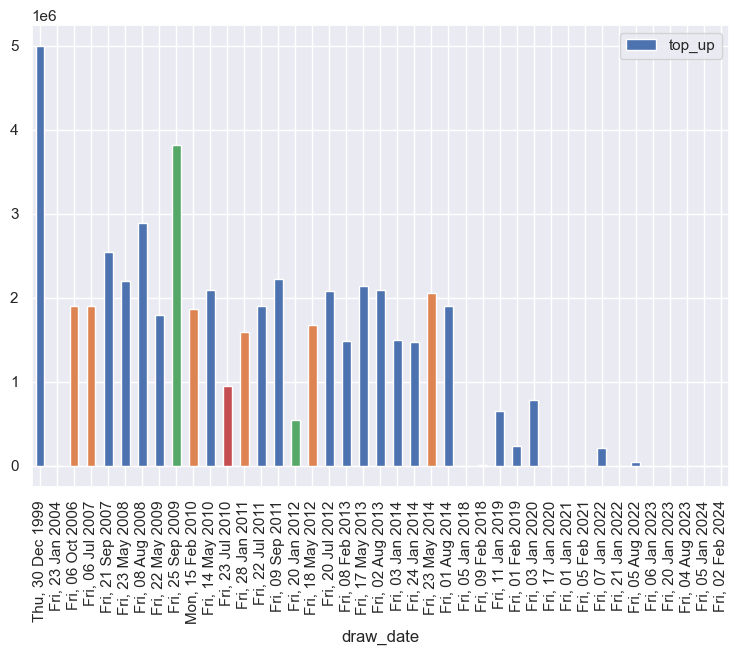

In [50]:
friday_draws['top_up'] = friday_draws['discrepency'] * friday_draws['format'].map({'456': 0.33, '496': 0.38})
friday_draws.plot.bar(x='draw_date', y='top_up', color=friday_draws['consecutive'].map(color_map), figsize=(9, 6));

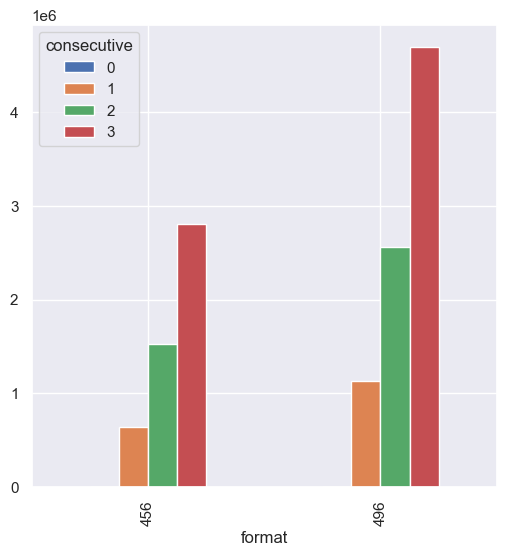

In [51]:
usual_draws.groupby(['format', 'consecutive'])['snowballed_1'].mean().unstack().plot.bar(figsize=(6, 6));

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/1598217421.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wo_snowball = usual_draws[draws['consecutive'] == 0]


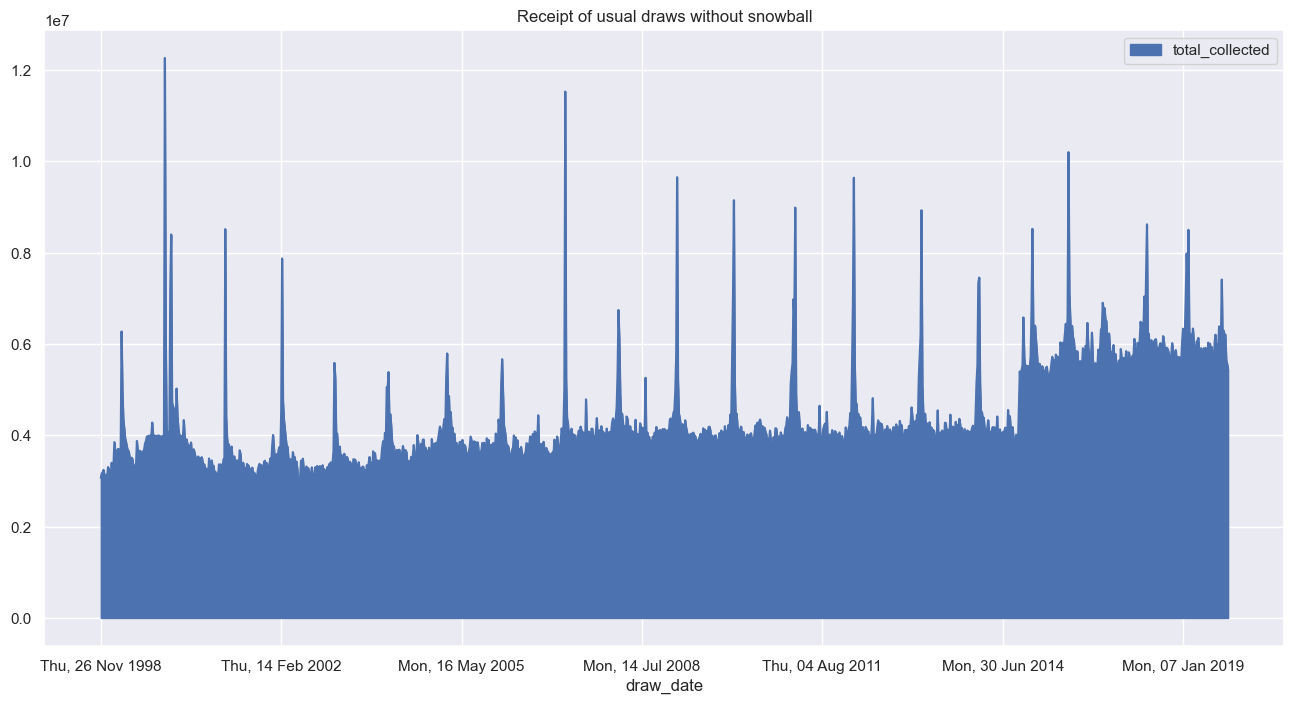

In [52]:
wo_snowball = usual_draws[draws['consecutive'] == 0]
ax = wo_snowball.plot.area(x='draw_date', y='total_collected', color=color_map[0], figsize=(16, 8));
ax.set_title('Receipt of usual draws without snowball');

## History

In [53]:
draws['year'] = pd.to_datetime(draws['draw_date']).dt.to_period('Y').astype(str)

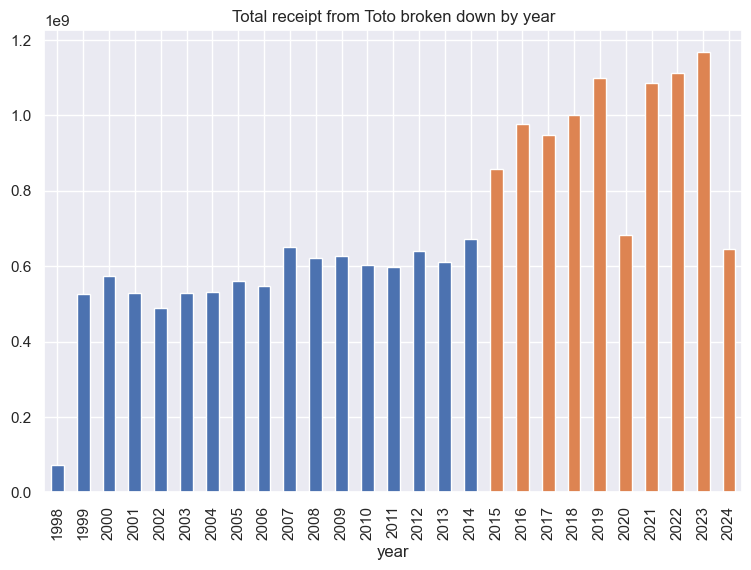

In [54]:
receipt_yearly = draws.groupby('year')['total_collected'].sum()
ax = receipt_yearly.plot.bar(color=receipt_yearly.index.map(lambda y: color_map[1] if y >= '2015' else color_map[0]), figsize=(9, 6));
ax.set_title('Total receipt from Toto broken down by year');

Compute average growth after format change

In [55]:
(receipt_yearly['2019'] / receipt_yearly['2014']) ** 0.2 - 1

0.10366212795193497

**Observation**: Broken down by year, total receipt increases sharply after format change averaging yearly growth over the period 2015 to 2019.

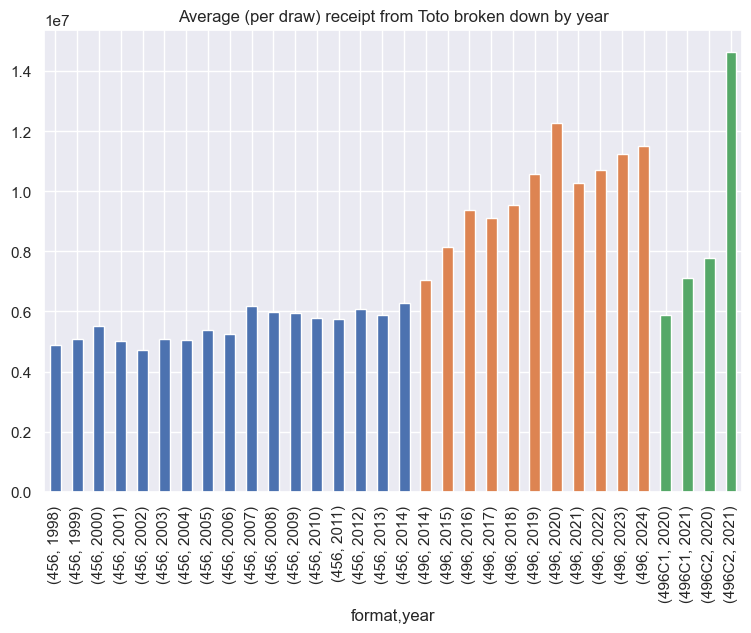

In [56]:
receipt_per_draw = draws.groupby(['format','year'])['total_collected'].mean()
ax = receipt_per_draw.plot.bar(color=receipt_per_draw.index.get_level_values(0).map({'456': color_map[0], '496': color_map[1], '496C1': color_map[2], '496C2': color_map[2]}), figsize=(9, 6))
ax.set_title('Average (per draw) receipt from Toto broken down by year');

## Expected payoff

In [57]:
usual_draws.groupby(['consecutive', 'format'])['payoff'].mean().unstack()

format,456,496
consecutive,,
0,0.427609,0.357054
1,0.522660,0.440475
2,0.614141,0.521128
3,0.668778,0.750589


In [58]:
mean_payoff = draws['total_distributed'].sum() / draws['total_collected'].sum()
mean_payoff

0.5070661356102247

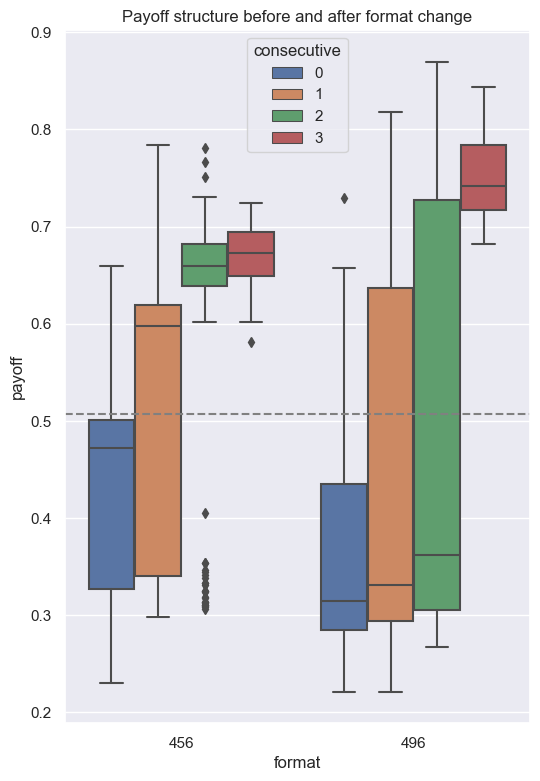

In [59]:
plt.figure(figsize=(6, 9))
ax = sns.boxplot(data=usual_draws, y='payoff', x='format', hue='consecutive')
ax.axhline(mean_payoff, color='grey', linestyle='--')
ax.set_title('Payoff structure before and after format change');

**Observation**: With old "456" format, payoff is better than long run average as long there is snowballing. After format change that is no longer true: payoff is only better than long run average in cascade draws (3 consecutive snowballs). Expected payoff of cascade draws is the highest at 0.75.

### Expected payoff post-Circuit Breaker

In [60]:
draws[draws.index >= 3568].groupby('consecutive')[['total_collected', 'payoff']].mean()

,total_collected,payoff
consecutive,,
0,7.722075e+06,0.381446
1,9.697342e+06,0.531337
2,1.603275e+07,0.559022
3,3.170698e+07,0.679187


### Expected payoff of special draws

In [61]:
hong_bao_draws.groupby('format')[['total_collected', 'payoff']].mean()

,total_collected,payoff
format,,
456,3.925761e+07,0.599881
496,5.960221e+07,0.535969
496C2,5.389926e+07,0.508962


In [62]:
friday_draws.groupby('format')[['total_collected', 'payoff']].mean()

,total_collected,payoff
format,,
456,2.042410e+07,0.618626
496,2.914430e+07,0.503396
496C2,2.745848e+07,0.340340


**Observation**: Compared to cascade draws Hong Bao draws and Friday draws are less value for money even with the jackpot prize top up.

## Why more participants is better

In [63]:
shares_subset = shares[(shares['group'] == 'Group 1') & shares['snowballed'].isna() & (shares['numberOfShares'] > 0) & (shares['numberOfShares'] <= 10)]
shares_subset = pd.merge(shares_subset, draws, how='inner', right_index=True, left_on='draw')
shares_subset = shares_subset[~shares_subset['unusual'] & (shares_subset['format'] == '456')]

In [64]:
shares_subset['more_or_less'] = shares_subset['total_collected'] > shares_subset['total_collected'].median()
pivot = shares_subset.pivot_table(['prize_pool', 'numberOfShares', 'shareAmount'], index='more_or_less', aggfunc='mean')
pd.concat([pivot['prize_pool'].apply(format_num), pivot['numberOfShares'].apply('{:.5f}'.format), pivot['shareAmount'].apply(format_num)], axis=1)

,prize_pool,numberOfShares,shareAmount
more_or_less,,,
False,"1,796,652",1.58621,"460,950"
True,"2,243,732",1.71280,"547,856"


## Monday vs Thursday

In [65]:
usual_draws.loc[usual_draws['day_of_week'] == 6, 'day_of_week'] = 1

In [66]:
mon_thur_breakdown = usual_draws.groupby(['format', 'consecutive', 'day_of_week'])['total_collected'].agg(['count', 'mean'])

In [67]:
mean_receipt_by_consecutive = usual_draws.groupby(['format', 'consecutive'])['total_collected'].mean()
mon_thur_diff = ((mon_thur_breakdown['mean'] / mon_thur_breakdown.index.map(lambda i: mean_receipt_by_consecutive[i[:-1]]) - 1) * 100).apply('{:.2f}%'.format)
mon_thur_diff.name = 'diff'

In [68]:
pd.concat([mon_thur_breakdown.applymap(format_num), mon_thur_diff], axis=1)

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/3130339557.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pd.concat([mon_thur_breakdown.applymap(format_num), mon_thur_diff], axis=1)


count        mean    diff
format consecutive day_of_week                          
456    0           1             533   4,109,576   3.12%
                   4             486   3,848,987  -3.42%
       1           1             216   5,757,457   2.52%
                   4             217   5,475,583  -2.50%
       2           1              63   9,438,168   6.20%
                   4              77   8,436,555  -5.07%
       3           1              16  16,202,614  -0.68%
                   4               6  16,608,226   1.81%
496    0           1             129   6,080,614   2.26%
                   4             103   5,777,715  -2.83%
       1           1              75   8,045,967   4.38%
                   4              95   7,442,136  -3.46%
       2           1              60  11,409,572   2.64%
                   4              46  10,733,415  -3.44%
       3           1              22  19,404,942  -0.53%
                   4              30  19,585,604   0.39%

**Observation**: Monday draws tend to pull higher receipts due to more time having elpased since last draw. Difference can be as high as 11%. Though thiis pattern is not seen in cascade draws.

## Winning shares

In [69]:
shares['format'] = shares['draw'].map(draws['format'])
shares_subset = shares[~shares['draw'].map(draws['unusual']) & (shares['draw'] < 3568)].copy()

Winning share broken down by prize group

In [70]:
shares_subset.groupby(['format', 'group'])['shareAmount'].describe().applymap(format_num)

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/233427342.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shares_subset.groupby(['format', 'group'])['shareAmount'].describe().applymap(format_num)


count       mean        std      min        25%        50%  \
format group                                                                 
456    Group 1  1,614    893,004    651,528   21,301    557,751    661,070   
       Group 2  1,614     69,779     58,887    2,018     36,985     52,664   
       Group 3  1,614      1,351        363      194      1,115      1,354   
       Group 4  1,614        527        127      161        442        534   
       Group 5  1,614         30          0       30         30         30   
       Group 6  1,614         20          0       20         20         20   
496    Group 1    560  2,647,944  2,021,274  222,182  1,117,079  2,328,774   
       Group 2    560    211,950    387,803   23,758     77,292    121,084   
       Group 3    560      1,781        478      335      1,486      1,763   
       Group 4    560        382         91      106        326        384   
       Group 5    560         50          0       50         50         50   
       Group 6    560         25          0       25         25         25   
       Group 7    560         10          0       10         10         10   

                      75%        max  
format group                          
456    Group 1  1,272,189  6,518,692  
       Group 2     80,149    626,141  
       Group 3      1,590      2,817  
       Group 4        615      1,028  
       Group 5         30         30  
       Group 6         20         20  
496    Group 1  2,944,456  9,731,377  
       Group 2    230,093  4,559,710  
       Group 3      2,075      3,689  
       Group 4        443        751  
       Group 5         50         50  
       Group 6         25         25  
       Group 7         10         10

In [71]:
shares_subset[shares_subset['group'] <= 'Group 2'].groupby(['format', 'group'])['numberOfShares'].describe().applymap('{:,.1f}'.format)

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/2859595819.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shares_subset[shares_subset['group'] <= 'Group 2'].groupby(['format', 'group'])['numberOfShares'].describe().applymap('{:,.1f}'.format)


count mean  std  min  25%  50%  75%    max
format group                                                
456    Group 1  1,614.0  1.2  1.6  0.0  0.0  1.0  2.0   29.0
       Group 2  1,614.0  7.0  6.7  0.0  4.0  6.0  9.0  196.0
496    Group 1    560.0  0.5  0.9  0.0  0.0  0.0  1.0    5.0
       Group 2    560.0  3.4  2.8  0.0  1.0  3.0  5.0   15.0

**Observation**: Average number of Group 1 shares after format change decreased below 1.0 meaning in a non-snowball draw jackpot prize will mostly likely be unclaimed.

## Buying behavior

Pivot `outlets` to get frequencies of wins from different bet types being proxy for the number of tickets sold in each bet type

In [72]:
outlets['format'] = outlets['draw'].map(draws['format'])
pivot_bet_type = outlets[outlets['draw'] < 3568].pivot_table('draw', index='bet_type', columns=['format', outlets['draw'].map(draws['consecutive'])], aggfunc='count')

In [73]:
bet_types = [
    'Ordinary Entry',
    'System 7 Entry',
    'System 8 Entry',
    'System 9 Entry',
    'System 10 Entry',
    'System 11 Entry',
    'System 12 Entry',
    'iTOTO - System 12',
    'System Roll Entry'
]
pivot_bet_type = pivot_bet_type.reindex(index=bet_types)
pivot_bet_type

format                456                          496                     
draw                    0       1      2      3      0      1      2      3
bet_type                                                                   
Ordinary Entry     1920.0  1009.0  372.0   70.0  361.0  275.0  196.0  183.0
System 7 Entry     2311.0  1232.0  485.0  117.0  280.0  249.0  225.0  196.0
System 8 Entry      375.0   218.0  116.0   27.0   52.0   44.0   49.0   47.0
System 9 Entry      120.0    76.0   45.0    8.0   10.0   11.0   10.0    7.0
System 10 Entry      66.0    54.0   15.0    7.0    5.0    7.0    4.0    5.0
System 11 Entry      17.0     8.0    8.0    1.0    NaN    NaN    3.0    2.0
System 12 Entry      45.0    36.0   14.0    4.0    5.0    4.0    7.0    6.0
iTOTO - System 12     NaN     NaN    NaN    NaN  471.0  476.0  419.0  713.0
System Roll Entry   253.0   153.0   64.0   19.0   13.0   14.0   11.0   16.0

Correction for iToto

In [74]:
pivot_bet_type.loc[pivot_bet_type.index == 'iTOTO - System 12'] /= 28

Normalize to percentage

In [75]:
pivot_bet_type_total = pivot_bet_type.sum(axis=0)
pivot_bet_type = pivot_bet_type.apply(lambda row: row / pivot_bet_type_total * 100, axis=1)

In [76]:
pivot_bet_type['456'].applymap('{:,.1f}%'.format)

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/11946535.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_bet_type['456'].applymap('{:,.1f}%'.format)


draw,0,1,2,3
bet_type,,,,
Ordinary Entry,37.6%,36.2%,33.2%,27.7%
System 7 Entry,45.3%,44.2%,43.3%,46.2%
System 8 Entry,7.3%,7.8%,10.4%,10.7%
System 9 Entry,2.3%,2.7%,4.0%,3.2%
System 10 Entry,1.3%,1.9%,1.3%,2.8%
System 11 Entry,0.3%,0.3%,0.7%,0.4%
System 12 Entry,0.9%,1.3%,1.3%,1.6%
iTOTO - System 12,nan%,nan%,nan%,nan%
System Roll Entry,5.0%,5.5%,5.7%,7.5%


In [77]:
pivot_bet_type['496'].applymap('{:,.1f}%'.format)

/var/folders/j5/3__09qbn23992bj8tqg6vyvr0000gn/T/ipykernel_40081/4240313907.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_bet_type['496'].applymap('{:,.1f}%'.format)


draw,0,1,2,3
bet_type,,,,
Ordinary Entry,48.6%,44.3%,37.7%,37.5%
System 7 Entry,37.7%,40.1%,43.3%,40.2%
System 8 Entry,7.0%,7.1%,9.4%,9.6%
System 9 Entry,1.3%,1.8%,1.9%,1.4%
System 10 Entry,0.7%,1.1%,0.8%,1.0%
System 11 Entry,nan%,nan%,0.6%,0.4%
System 12 Entry,0.7%,0.6%,1.3%,1.2%
iTOTO - System 12,2.3%,2.7%,2.9%,5.2%
System Roll Entry,1.8%,2.3%,2.1%,3.3%


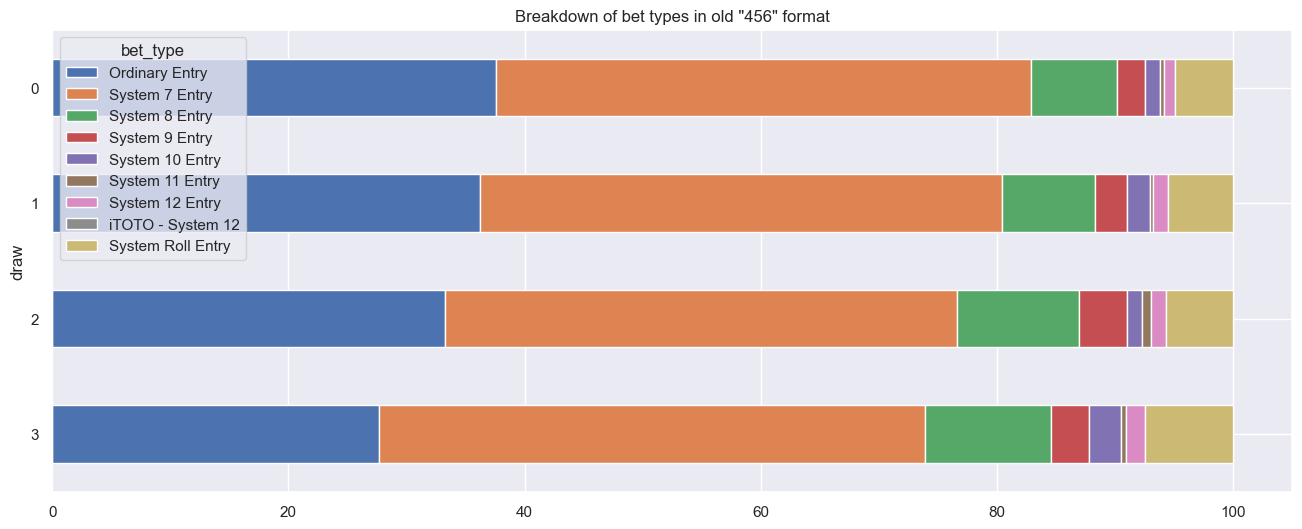

In [78]:
ax = pivot_bet_type['456'].T.iloc[::-1, :].plot.barh(stacked=True, figsize=(16, 6))
ax.set_title('Breakdown of bet types in old "456" format');

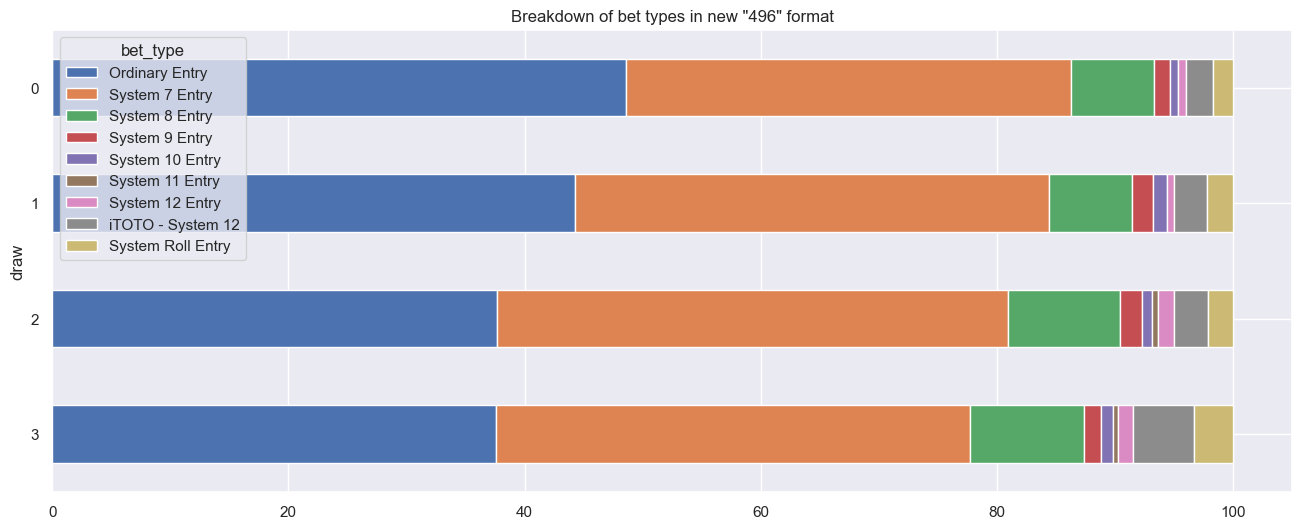

In [79]:
ax = pivot_bet_type['496'].T.iloc[::-1, :].reindex(index=[3, 2, 1, 0]).plot.barh(stacked=True, figsize=(16, 6))
ax.set_title('Breakdown of bet types in new "496" format');

**Observation**: Punters place bigger bets when snowball grows. In cascaded draws, significantly more people bought System Roll or iToto tickets. After format change, the number System Entry tickets sold decreased as unit price doubled.

In [80]:
pivot_quickpick = outlets[outlets['draw'] < 3568].pivot_table('quickpick', index='bet_type', columns='format', aggfunc='mean')
pivot_quickpick = pivot_quickpick.reindex(index=bet_types)
pivot_quickpick

format,456,496
bet_type,,
Ordinary Entry,0.677247,0.663054
System 7 Entry,0.565018,0.620000
System 8 Entry,0.298913,0.453125
System 9 Entry,0.261044,0.315789
System 10 Entry,0.176056,0.285714
System 11 Entry,0.088235,0.200000
System 12 Entry,0.191919,0.545455
iTOTO - System 12,NaN,1.000000
System Roll Entry,0.319018,0.537037


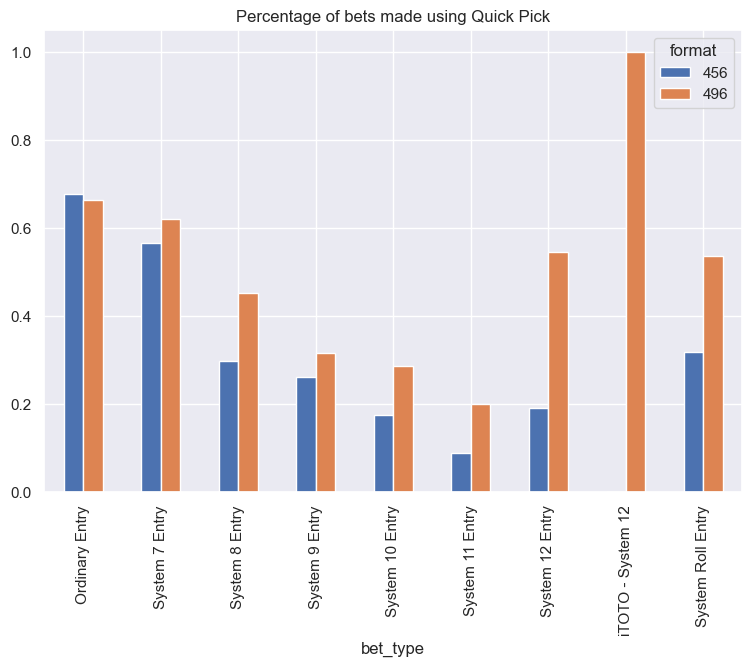

In [81]:
ax = pivot_quickpick.plot.bar(figsize=(9, 6))
ax.set_title('Percentage of bets made using Quick Pick');

## Predicting prize pool

In [82]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(sns.color_palette(n_colors=3).as_hex())

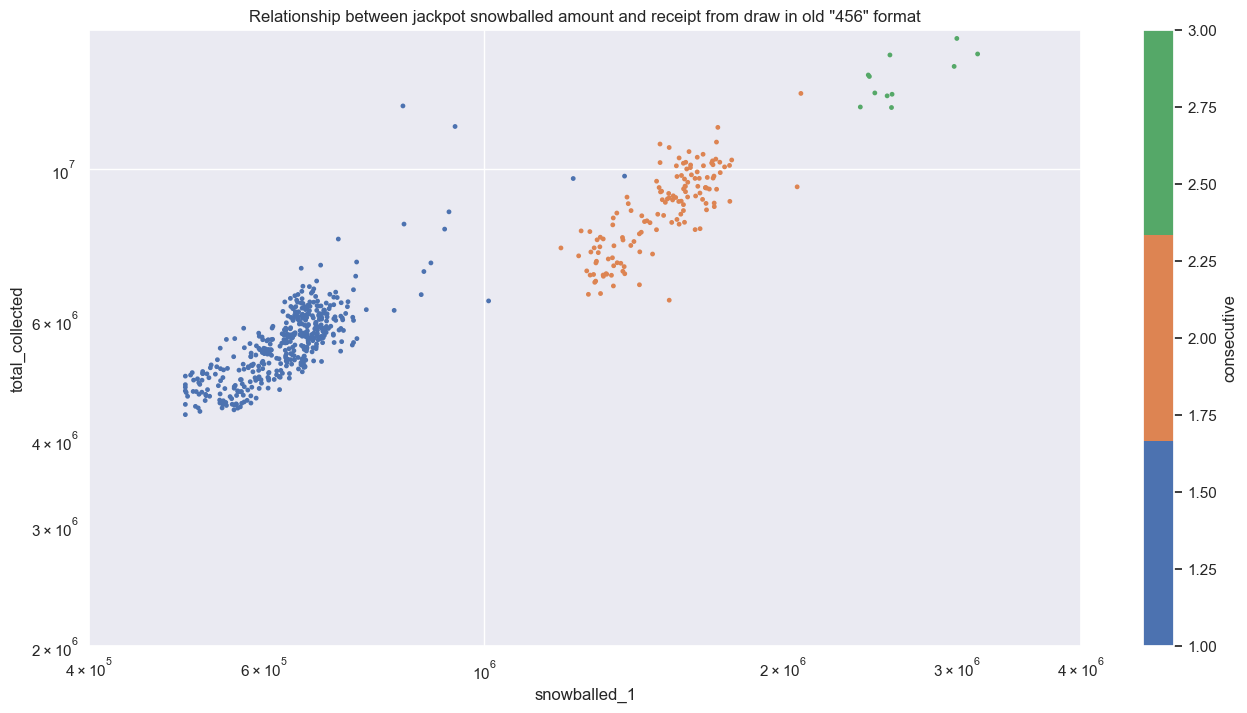

In [83]:
w_snowball = usual_draws[usual_draws['consecutive'] > 0]
ax = w_snowball[w_snowball['format'] == '456'].plot.scatter(x='snowballed_1', y='total_collected', c='consecutive', s=6,
                                                            logx=True, logy=True, colormap=cmap, figsize=(16, 8))
ax.axis([400000, 4000000, 2000000, 16000000])
ax.set_title('Relationship between jackpot snowballed amount and receipt from draw in old "456" format');

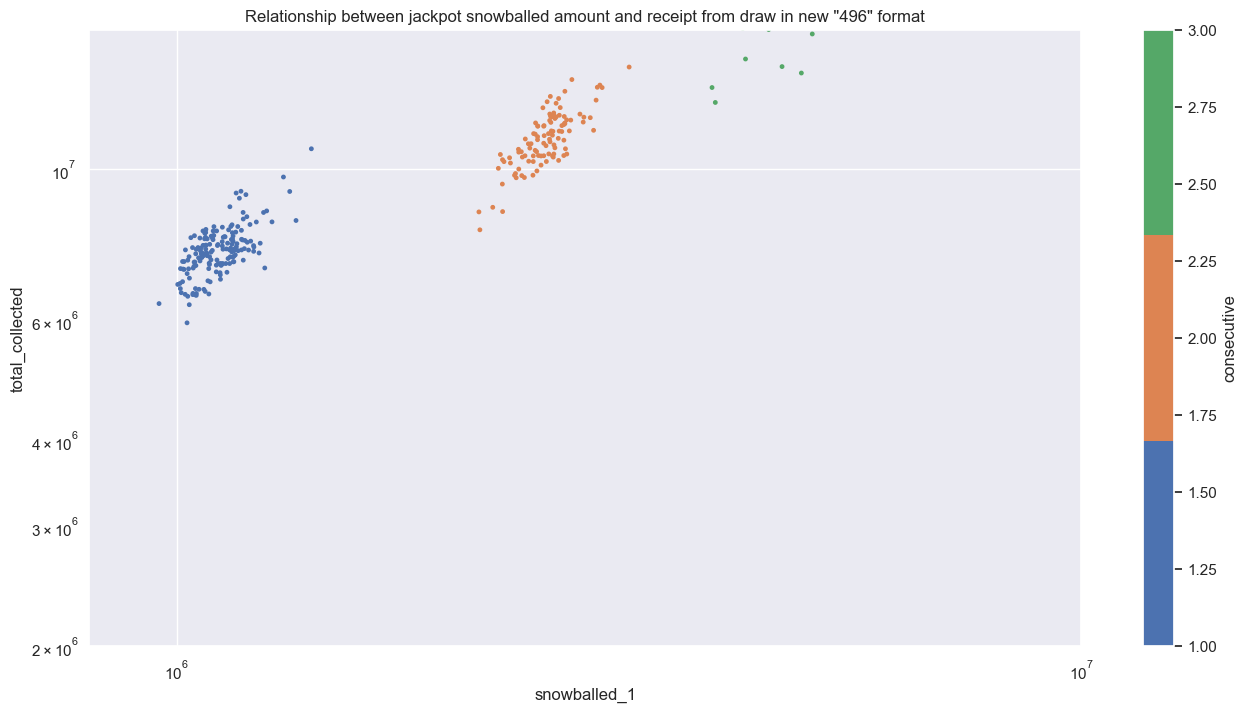

In [84]:
ax = w_snowball[w_snowball['format'] == '496'].plot.scatter(x='snowballed_1', y='total_collected', c='consecutive', s=6,
                                                            logx=True, logy=True, colormap=cmap, figsize=(16, 8))
ax.axis([800000, 10000000, 2000000, 16000000])
ax.set_title('Relationship between jackpot snowballed amount and receipt from draw in new "496" format');

## Regression

In [85]:
draws['last_unusual'] = draws['unusual'].shift(1, fill_value=False)
draws['last_consecutive'] = draws['consecutive'].shift(1)
draws['last_collected'] = draws['total_collected'].shift(1)

In [86]:
draws_subset = draws[draws.index < 3568].iloc[1:, :]
draws_subset = draws_subset[~draws_subset['unusual'] & ~draws_subset['last_unusual']]
draws_subset['group'] = (draws_subset['consecutive'] - draws_subset['last_consecutive']).astype('int').astype('category')

In [87]:
cmap = ListedColormap(sns.color_palette(n_colors=5).as_hex())

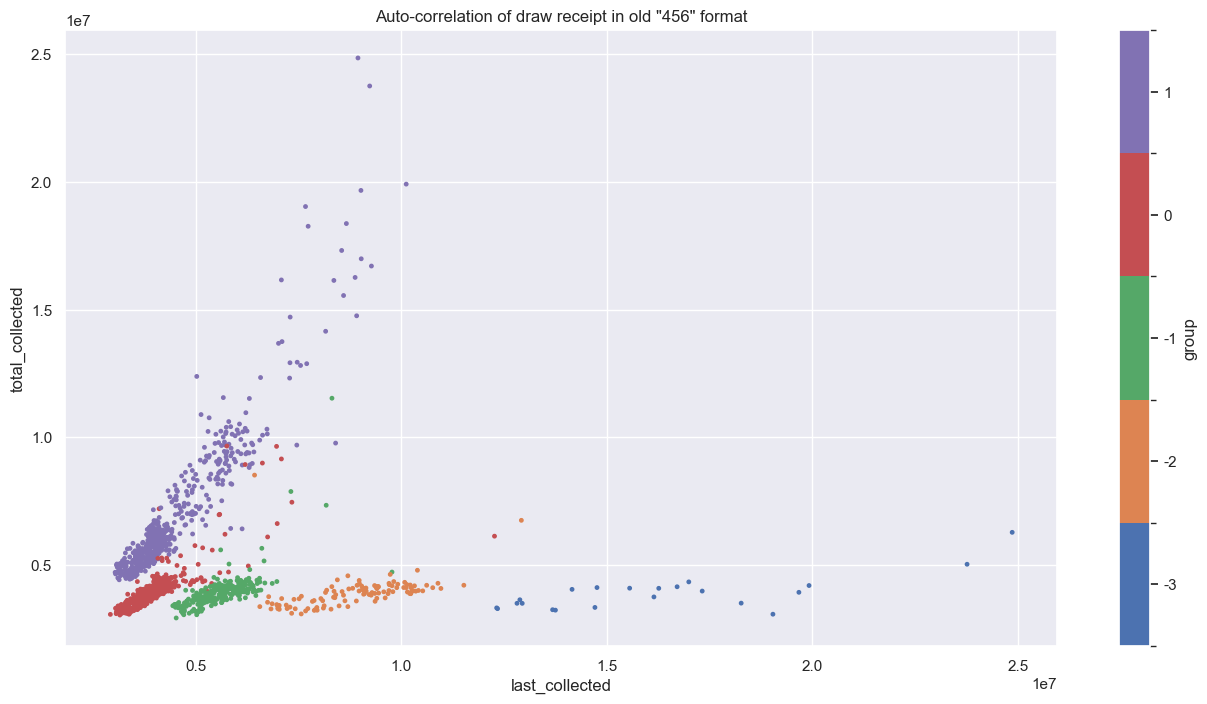

In [88]:
ax = draws_subset[draws_subset['format'] == '456'].plot.scatter(x='last_collected', y='total_collected', c='group',
                                                                s=6, colormap=cmap, figsize=(16, 8))
ax.set_title('Auto-correlation of draw receipt in old "456" format');

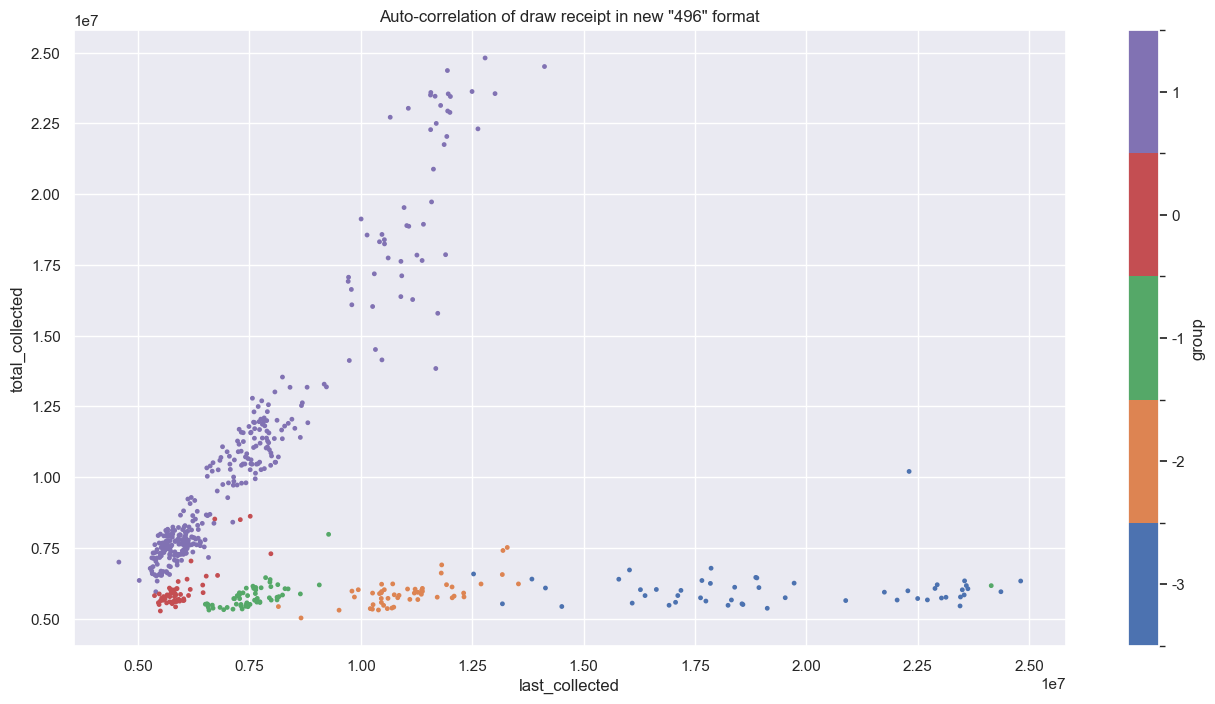

In [89]:
ax = draws_subset[(draws_subset['format'] == '496')].plot.scatter(x='last_collected', y='total_collected', c='group',
                                                                  s=6, colormap=cmap, figsize=(16, 8));
ax.set_title('Auto-correlation of draw receipt in new "496" format');

In [90]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def ols(data, subset = None):
    model = smf.ols('total_collected ~ group:last_collected + group - 1', data, subset=subset)
    fitted = model.fit()
    return fitted, model

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
fitted_456, model_456 = ols(draws_subset, draws_subset['format'] == '456')
fitted_496, model_496 = ols(draws_subset, draws_subset['format'] == '496')

In [ ]:
fitted_456.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        total_collected   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1545.
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:58:12   Log-Likelihood:                -23322.
No. Observations:                1568   AIC:                         4.666e+04
Df Residuals:                    1558   BIC:                         4.672e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
group[-3]                 1.389e+06   7.27e+05      1.909      0.056   -3.81e+04    2.82e+06
group[-2]                 2.067e+06   4.76e+05      4.344      0.000    1.13e+06       3e+06
group[-1]                  4.86e+04   3.66e+05      0.133      0.894   -6.69e+05    7.66e+05
group[0]                  5.669e+05   1.79e+05      3.164      0.002    2.15e+05    9.18e+05
group[1]                 -2.607e+06   1.14e+05    -22.855      0.000   -2.83e+06   -2.38e+06
group[-3]:last_collected     0.1532      0.044      3.511      0.000       0.068       0.239
group[-2]:last_collected     0.2076      0.053      3.897      0.000       0.103       0.312
group[-1]:last_collected     0.6931      0.065     10.677      0.000       0.566       0.820
group[0]:last_collected      0.8591      0.045     19.259      0.000       0.772       0.947
group[1]:last_collected      2.1271      0.025     85.261      0.000       2.078       2.176
==============================================================================
Omnibus:                     1120.490   Durbin-Watson:                   2.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            81467.826
Skew:                           2.638   Prob(JB):                         0.00
Kurtosis:                      37.916   Cond. No.                     1.15e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
fitted_496.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        total_collected   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     1106.
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        14:58:12   Log-Likelihood:                -8298.9
No. Observations:                 547   AIC:                         1.662e+04
Df Residuals:                     537   BIC:                         1.666e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
group[-3]                 5.751e+06   7.97e+05      7.219      0.000    4.19e+06    7.32e+06
group[-2]                 2.616e+06   1.36e+06      1.917      0.056   -6.48e+04     5.3e+06
group[-1]                 5.351e+06   4.48e+05     11.940      0.000    4.47e+06    6.23e+06
group[0]                 -7.315e+05   1.53e+06     -0.478      0.633   -3.74e+06    2.28e+06
group[1]                 -5.226e+06   2.01e+05    -25.979      0.000   -5.62e+06   -4.83e+06
group[-3]:last_collected     0.0143      0.040      0.355      0.723      -0.065       0.094
group[-2]:last_collected     0.2979      0.123      2.424      0.016       0.056       0.539
group[-1]:last_collected     0.0556      0.055      1.003      0.316      -0.053       0.164
group[0]:last_collected      1.1322      0.256      4.421      0.000       0.629       1.635
group[1]:last_collected      2.1822      0.027     81.695      0.000       2.130       2.235
==============================================================================
Omnibus:                       96.884   Durbin-Watson:                   2.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1569.470
Skew:                          -0.071   Prob(JB):                         0.00
Kurtosis:                      11.297   Cond. No.                     2.27e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.27e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1


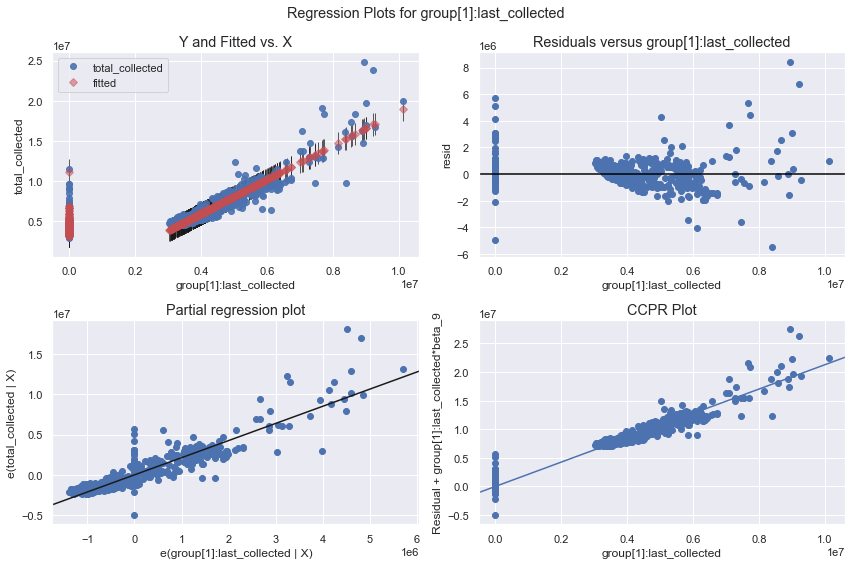

In [ ]:
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(fitted_456, 'group[1]:last_collected', fig=fig);

eval_env: 1


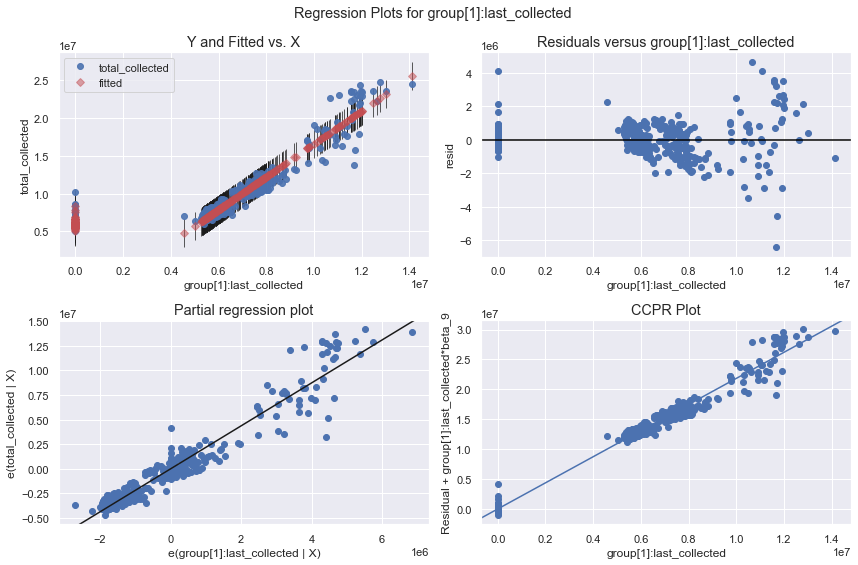

In [ ]:
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(fitted_496, 'group[1]:last_collected', fig=fig);

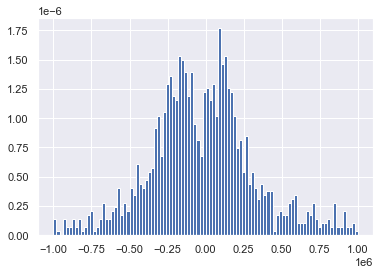

In [ ]:
fitted_456.resid.hist(bins=100, density=True, range=(-1000000, 1000000));

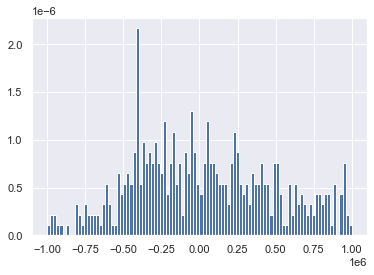

In [ ]:
fitted_496.resid.hist(bins=100, density=True, range=(-1000000, 1000000));

## ANOVA

In [ ]:
reset_draws = draws_subset.loc[draws_subset['consecutive'] == 0, :]
reset_draws['group'].cat.remove_categories(1, inplace=True)

/Users/yongjun.thong/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


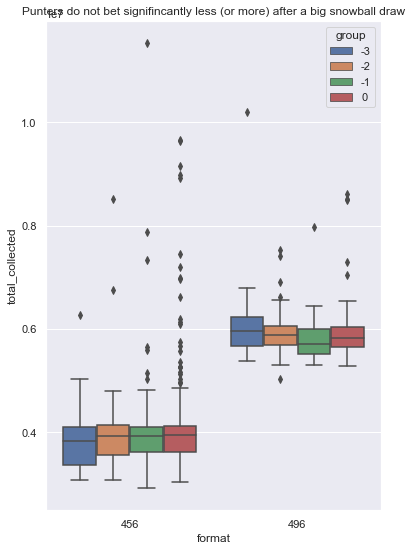

In [ ]:
plt.figure(figsize=(6, 9))
ax = sns.boxplot(data=reset_draws, y='total_collected', x='format', hue='group')
ax.set_title('Punters do not bet signifincantly less (or more) after a big snowball draw');

In [ ]:
model = smf.ols('total_collected ~ format + group + format:group', reset_draws)
fitted = model.fit()
sm.stats.anova_lm(fitted, typ=2)

,sum_sq,df,F,PR(>F)
format,5.978357e+14,1.0,1269.717306,6.845845e-190
group,1.488990e+12,3.0,1.054134,3.676759e-01
format:group,1.413293e+12,3.0,1.000544,3.917619e-01
Residual,5.607723e+14,1191.0,NaN,NaN


**Observation**: ANOVA result supports null hypothesis. No sign of intertemporal substitution. Receipt from non-snowball draws (reset draws) is statistically independent of the last draw (number of consecutive snowballs). i.e. After "spurging" on a big draw, punter does not cut spending in the following draw.

## Circuit Breaker

In [ ]:
cb_draws = draws.loc[(draws['format'] != '456') & ~draws['unusual'], :]

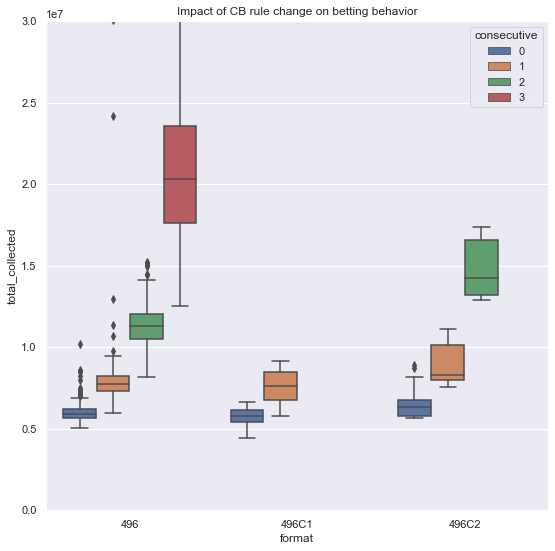

In [ ]:
plt.figure(figsize=(9, 9))
ax = sns.boxplot(data=cb_draws, y='total_collected', x='format', hue='consecutive')
ax.set_ylim(0, 3e7);
ax.set_title('Impact of CB rule change on betting behavior');